TODO:
- add visualization with feature importance and its description [reference for visualization](https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793)

# Instagram Like Prediction @310ai Competition - Modeling, Visualization & Evaluation

This notebook is a continuation of ***Data*** notebook. In this part of project we will train the predictive model, analyze it, visualize its output and evaluate it. The reason for this separation, is to make the notebooks easier to understand and less dependent on each other, especially for this case since the Instagram showed that it reguralry changing its api and bot mitigation methods. Multiple stages of this project have checkpoints, thus the notebook will run without issues.

As we pointed out in the previous notebook, we will use **XGBoost 1.7** as the algorithm. So let's without further ado, dive into it.

In [2]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
sns.set_theme(style='darkgrid')

First thing first, we must load the data, also we have some identifying features, called shortcode, username and id, which will not affect the accuracy of the model, thus we can drop these features all together.

In [3]:
df = pd.read_csv('Data/main v3.0.csv')
df.drop(columns=['Unnamed: 0', 'shortcode', 'username', 'id'], inplace=True)
df.head()

,post_type,like,comment,category_name,follower,following,ar_effect,type_business,type_professional,verified,...,reel_avg_view,reel_avg_comment,reel_avg_like,reel_avg_duration,reel_frequency,media_count,media_avg_comment,media_avg_like,media_frequency,object
0,GraphSidecar,390465,7037,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,"pot, flowerpot"
1,GraphSidecar,320587,6746,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,"rock_crab, Cancer_irroratus"
2,GraphSidecar,480033,9096,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,"feather_boa, boa"
3,GraphSidecar,351673,6692,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,"teddy, teddy_bear"
4,GraphImage,273314,6878,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,wig


Now we can separate independent and dependent variables. Usually we cal independent variables X and dependent variables y.

In [4]:
# remove objects from instagram detection algorithm and only use efficient net algorithm
exclude_columns = [
    'like',
]
X, y = df.loc[:, ~df.columns.isin(exclude_columns)].copy(), df[['like']].copy()

As we said in the previous notebook, XGBoost since the version of 1.7 is capable of working with categorical variables, but before casting the categorical variables through the model, we must change the type of those features to `categorical` in pandas.

In [5]:
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
for feature in categorical_features:
    X[feature] = X[feature].astype('category')

Now we can split the data into training and validation. We will use the 25% of data as validation set.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

### What architecture and pre trained models -if any- you used?

In this cell we will define hyperparameters value for model. Have in mind that since we will perform a cross-validation, parameters are actually list of parameters to find the best one among their combination.

In [12]:
model = xgb.XGBRegressor(tree_method='hist', enable_categorical=True)

params = {
    'booster': ['gbtree', 'dart'],
    'eta': [0.1, 0.05, 0.01],
    'subsample': [.8, .9, .1],
    'max_depth': np.arange(14, 17),
    'subsample': [.8, .9, 1],
    'reg_lambda': np.arange(0.5, 1.25, 0.25),
}

grid = GridSearchCV(model, param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X, y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END booster=gbtree, eta=0.1, max_depth=14, reg_lambda=0.5, subsample=0.8;, score=(train=1.000, test=0.269) total time=   2.6s
[CV 2/5] END booster=gbtree, eta=0.1, max_depth=14, reg_lambda=0.5, subsample=0.8;, score=(train=1.000, test=0.443) total time=   2.2s
[CV 3/5] END booster=gbtree, eta=0.1, max_depth=14, reg_lambda=0.5, subsample=0.8;, score=(train=1.000, test=0.458) total time=   2.3s
[CV 4/5] END booster=gbtree, eta=0.1, max_depth=14, reg_lambda=0.5, subsample=0.8;, score=(train=1.000, test=0.514) total time=   2.7s
[CV 5/5] END booster=gbtree, eta=0.1, max_depth=14, reg_lambda=0.5, subsample=0.8;, score=(train=1.000, test=0.448) total time=   3.4s
[CV 1/5] END booster=gbtree, eta=0.1, max_depth=14, reg_lambda=0.5, subsample=0.9;, score=(train=1.000, test=0.306) total time=   3.8s
[CV 2/5] END booster=gbtree, eta=0.1, max_depth=14, reg_lambda=0.5, subsample=0.9;, score=(train=1.000, test=0.420) total time=

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'booster': ['gbtree', 'dart'],
                         'eta': [0.1, 0.05, 0.01],
                         'max_depth': array([14, 15, 16]),
                         'reg_lambda': array([0.5 , 0.75, 1.  ]),
                         'subsample': [0.8, 0.9, 1]},
             return_train_score=True, verbose=3)

In [13]:
print(f'best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

best hyperparameters are: {'booster': 'dart', 'eta': 0.1, 'max_depth': 16, 'reg_lambda': 0.5, 'subsample': 0.8} with the accuracy of: 0.45


The optimised hyperparameters for the model is:
- **Booster**: dart
- **ETA**: 0.1
- **Max Depth**: 16
- **Regularization Lambda**: 0.5
- **Subsample**: 0.8

Now that we have the optimsed hyperparameters, we can train the model with training dataset and asses it with validation set

Another fact to have in mind is the objective in use. We will use squared error as objective of this model, since this metric is more prone to the outliers.

In [7]:
model = xgb.XGBRegressor(tree_method='hist', enable_categorical=True, booster='dart', learning_rate=.1, max_depth=16, reg_lambda=.5, subsample=.8, objective='reg:squarederror', )

model.fit(X_train, y_train)
print(f'Model Score: {model.score(X_test, y_test):.2f}')

Model Score: 0.64


In the cell above you can see the Score of the model trained on the train dataset and validated on the validation dataset. Interesting feature that can be see here, is that model resulted in more accurate than the cross validation average. This means the model has high variance. Although we have used regularization to reduce the variance, but the best and main approach to reduce the variance is to collect more data for training. Since this approach is time-consuming and is out of the scope of the competition, we won't scrape the Instagram data further.

In [8]:
feature_importances = {
    key:f'{value:.8f}' for key,value in zip(X.columns, model.feature_importances_)
}
feature_importances = sorted(feature_importances.items(), key=lambda x:x[1], reverse=True)
feature_importances

[('media_avg_like', '0.93122119'),
 ('reel_avg_like', '0.02268074'),
 ('object', '0.01683310'),
 ('comment', '0.00603210'),
 ('follower', '0.00415417'),
 ('reel_frequency', '0.00313076'),
 ('type_professional', '0.00304449'),
 ('media_avg_comment', '0.00209312'),
 ('media_count', '0.00184148'),
 ('category_name', '0.00146313'),
 ('following', '0.00123751'),
 ('reel_avg_comment', '0.00101380'),
 ('reel_avg_view', '0.00100841'),
 ('reel_avg_duration', '0.00098057'),
 ('type_business', '0.00089110'),
 ('reel_count', '0.00086448'),
 ('ar_effect', '0.00057921'),
 ('post_type', '0.00053233'),
 ('media_frequency', '0.00039825'),
 ('verified', '0.00000003')]

As you can see in the table above, the most important feature on our dataset based on the trained model, is the **posts average like** by the huge margins. The content of the posted is the third most important feature based on this model. Since the difference between the importances is huge, We omit the media_avg_like and plot the other features in the graph below.

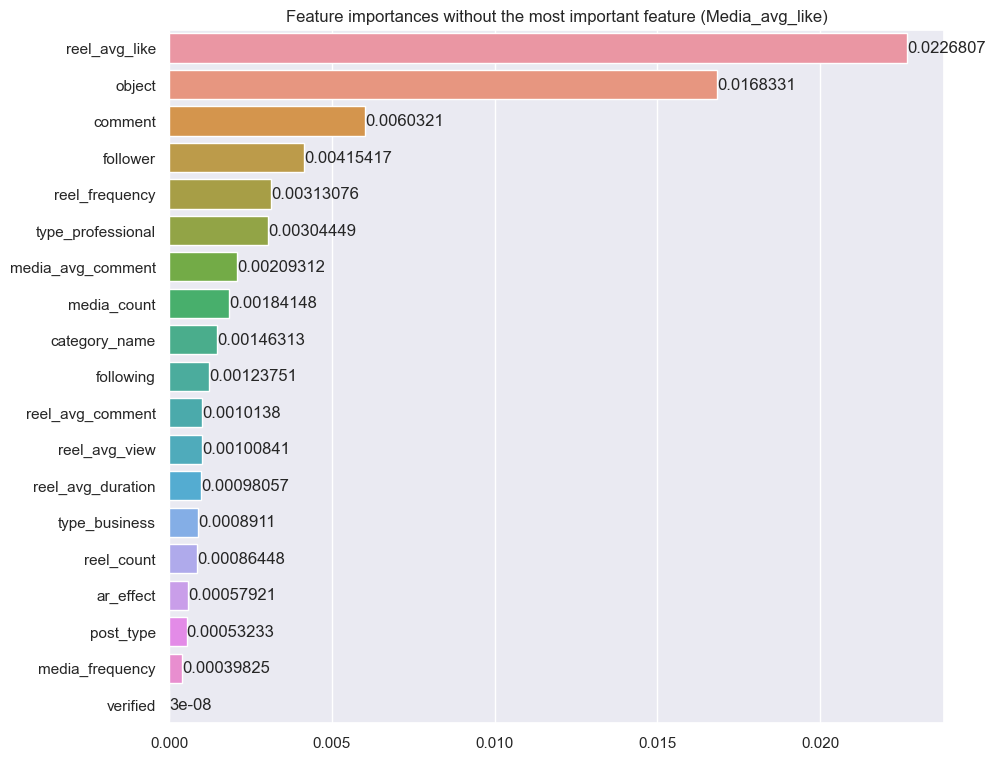

In [9]:
num_features = len(X.columns) - 1
fig = plt.figure(figsize=(10, 5 * num_features // 10))
temp_x = [float(x[1]) for x in feature_importances]
temp_x.remove(temp_x[0])
temp_y = [x[0] for x in feature_importances]
temp_y.remove(temp_y[0])
ax = sns.barplot(x=temp_x, y=temp_y)
ax.bar_label(ax.containers[0])
plt.title('Feature importances without the most important feature (Media_avg_like)')
plt.show()

Now lets visualize the models tree.

In [61]:
model.save_model('Models/xgb v2.0.json')

Now that we have the working model we will prepare the pipeline and use it as an operation.

----
`@Ramin F.` | [Email](ferdos.ramin@gmail.com) | [LinkedIn](https://www.linkedin.com/in/raminferdos/) | [GitHub](https://github.com/SimplyRamin) | [Personal Portfolio](https://simplyramin.github.io/)